<div style="width:90%; margin:0 auto; background-color:#F0F0F0; padding:20px; border-radius:8px; font-family:Arial, sans-serif">

<div style="display:flex; align-items:center; justify-content:space-between; margin-bottom:15px">
    <div style="width:100px; height:100px">
        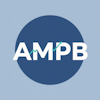
    </div>
    <div style="text-align:center; margin-bottom:20px">
        <h1 style="color:#9E0B0F; font-size:26px; margin-bottom:5px">Análisis de modelos predictivos en bolsa</h1>
        <h3 style="color:#D64550; font-size:22px; margin-top:0">Copyright (C) 2024-2025 MegaStorm Systems</h3>
    </div>
    <div style="width:192px; height:59px">
        <p style="max-width:100%; max-height:100%">
    </div>
</div>

<div style="width:60%; margin:0 auto; background-color:#E8E8E8; padding:20px; border-radius:10px; border:1px solid #D0D0D0; margin-bottom:20px; color:#333333; line-height:1.5; box-shadow:0 2px 4px rgba(0,0,0,0.05)">
    <p style="margin:0; font-size:15px">    
    This software is provided "as-is", without any express or implied<br>
    warranty. In no event will the authors be held liable for any damages<br>
    arising from the use of this software.<br><br>
    Permission is granted to anyone to use this software for any purpose,<br>
    including commercial applications, and to alter it and redistribute it<br>
    freely, subject to the following restrictions:<br><br>
    1. The origin of this software must not be misrepresented; you must not<br>
    claim that you wrote the original software. If you use this software<br>
    in a product, an acknowledgment in the product documentation would be<br>
    appreciated but is not required.<br>
    2. Altered source versions must be plainly marked as such, and must not be<br>
    misrepresented as being the original software.<br>
    3. This notice may not be removed or altered from any source distribution.
    </p>
</div>

<div style="text-align:center">
    <h2 style="font-size:24px; color:#9E0B0F; margin:0">Predictor Transformer v3.4</h2>
</div>

</div>

In [ ]:
# Importar librerías
import os
import argparse
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import optuna
from optuna.integration import TFKerasPruningCallback
import time
import warnings
import random

warnings.filterwarnings("ignore")

from ampblib import AMPBConfig, processData, generateEvaluation, updateNextDayExog, createReport, getExogVars, reverseTransformPredictions, createModelIdentity, createTFDataset, analyzeTrainingResults, createSequences, setupTensorflowDevice, resetRandomSeeds, calculateValidationSplit

In [ ]:
# 0. PARÁMETROS CONFIGURABLES
model_name = "Transformer"
model_version = "v3.4"

# Por defecto, permite ejecucion interactiva
default_transformation = "YeoJohnson" # "Log", "YeoJohnson"
default_exog_scaling = "Standard"   # "Standard"
default_exog_set_id = 123456    # 1="Directos", 2="IndicadoresTecnicos", 3="BigTech", 4="IndicesBursatiles", 5="IndicadoresEconomicos", 6="AnalisisSentimiento"

# Estos son fijos e internos, no los exponemos
nombre_archivo = "NVDA_2015-01-05_2025-05-23_SA.csv"
test_size = 60              # Número de días para el conjunto de test
optimize_hyperparams = True # True para optimizar hiperparámetros con Optuna
winsorization_value = 0.05  # Aplicar winsorización. Este valor es el mejor encontrado, 0.04 y 0.06 son peores y a mayor valor, mas valores que modidicamos.
run_backtesting = True      # True para Backtesting con Walk-Forward
fixed_epochs = 40
retrain_interval = 5        # Reentrenar modelo completo cada n días en backtesting. 5 es un valor adecuado, acelera la velocidad a cambio de perder un ~6% de rendimiento.
n_optuna_trials = 10        # Número de trials para Optuna
optuna_debug = False
cv_final_evaluation = False  # Cambiar a False para deshabilitar cross-validation
n_cv_folds = 5              # Separación de unos 8 meses

# Configuración determinista de TensorFlow
resetRandomSeeds(tensorflow_deterministic=True)
setupTensorflowDevice(use_gpu=False)

# Hiperparámetros fijos si optimize_hyperparams = False
fixed_sequence_length = 10
fixed_d_model = 128
fixed_num_heads = 4
fixed_num_transformer_blocks = 1
fixed_dropout_rate = 0.15
fixed_batch_size = 128
fixed_learning_rate = 0.000747599299995651
fixed_ff_dim = 128

# Argumentos de línea de comandos  
if AMPBConfig.INTERACTIVE:
    transformation = default_transformation
    exog_scaling = default_exog_scaling
    exog_set_id = default_exog_set_id
else:
    parser = argparse.ArgumentParser(description='Ejecuta modelo LSTM.')
    parser.add_argument('--transformation', type=str, default=default_transformation, choices=['None', 'Log', 'RetLog', 'YeoJohnson'])
    parser.add_argument('--exog_scaling', type=str, default=default_exog_scaling, choices=['None', 'Standard', 'MinMax'])
    def valid_exog(x):
        if not all(c in '123456' for c in str(x)): 
            raise argparse.ArgumentTypeError(f"Solo dígitos 1-6: {x}")
        return x
    parser.add_argument('--exog_set_id', type=valid_exog, default=default_exog_set_id)
    args = parser.parse_args()
    transformation = args.transformation
    exog_scaling = args.exog_scaling
    exog_set_id = args.exog_set_id

AMPBConfig.printHeader(title=f"Predictor {model_name} {model_version}", testsize=test_size, 
                     optimize=optimize_hyperparams, backtesting=run_backtesting, transform=transformation,
                     exogscaling=exog_scaling, exogsetid=exog_set_id)

In [ ]:
# 1. CARGA Y PREPARACIÓN DE DATOS
datos = pd.read_csv(nombre_archivo)

# Seleccionar columnas relevantes
mandatory_vars = ['Date','Close', 'Trend']

# Obtenemos lista de exogenas
exog_vars = getExogVars(exog_set_id)
df = datos[mandatory_vars + exog_vars]

# Convertir fechas a datetime
df['Date'] = pd.to_datetime(df['Date'])  

# Verificar y mostrar estadísticas básicas de los datos
print(f"Datos en crudo cargados: {len(df)} registros de {df['Date'].min()} a {df['Date'].max()}.")

# Detectar valores faltantes
missing = df.isna().sum()
missing = missing[missing > 0]

if not missing.empty:
    total_before = len(df)
    print("Valores faltantes por columna (se borrarán estas filas):")
    for col, cnt in missing.items():
        print(f"  • {col}: {cnt} valores faltantes")
    df = df.dropna().reset_index(drop=True)
    total_after = len(df)
    removed = total_before - total_after
    print(f"\nFilas borradas: {removed}")
else:
    print("No se encontraron valores faltantes.")

# Poner Date como indice
df.set_index('Date', inplace=True)
#df = df.asfreq('B', method='pad')  # Se asume que se trata de datos bursátiles (días hábiles)

print(f"\nDatos cargados: {AMPBConfig.COLOR_VALUE}{len(df)}{AMPBConfig.COLOR_RESET} registros. Variables exógenas seleccionadas: {AMPBConfig.COLOR_VALUE}{len(exog_vars)}{AMPBConfig.COLOR_RESET}\n{exog_vars}") 

In [ ]:
# 2. DIVISIÓN ENTRE ENTRENAMIENTO Y TEST

# 2A. Se utiliza el 90% de los datos para entrenamiento y el 10% para test
#split_index = int(len(df) * 0.90)
#df_train = df.iloc[:split_index].copy()
#df_test = df.iloc[split_index:].copy()

# 2B. Separamos datos de entrenamiento y de test por fecha
#split_date = pd.Timestamp('2024-12-01')
#df_train = df.loc[:split_date].copy()
#df_test = df.loc[split_date:].copy()

# 2C. Separamos por numero de dias.
df_train = df.iloc[:-test_size]
df_test = df.iloc[-test_size:]

# Guardar valores originales (inmutables para referencia futura)
y_train_original = df_train['Close'].copy()
y_test_original = df_test['Close'].copy()
X_train_original = df_train[exog_vars].copy()  
X_test_original = df_test[exog_vars].copy()

# Variables de trabajo (se transformarán/escalarán según configuración)
y_train = df_train['Close']
y_test  = df_test['Close']
X_train = df_train[exog_vars].copy()
X_test = df_test[exog_vars].copy()

print(f"\nDatos divididos:")
print(f"  Entrenamiento: {AMPBConfig.COLOR_VALUE}{len(y_train)}{AMPBConfig.COLOR_RESET} filas (hasta {y_train.index[-1].date()})")
print(f"  Test:          {AMPBConfig.COLOR_VALUE}{len(y_test)}{AMPBConfig.COLOR_RESET} filas (desde {y_test.index[0].date()})")

In [ ]:
# 3. PROCESAR DATOS: TRANSFORMACIONES, ESCALADO, ALINEACION Y ANALISIS DE CALIDAD
# Bajo determinadas circunstancias, puede abortar la ejecucion.
processing_results = processData(
    y_train, y_test, X_train, X_test,
    y_train_original, y_test_original, X_train_original, X_test_original,
    df_test, exog_vars, transformation, exog_scaling,
    winsorization_value=winsorization_value,   
    analyze=True               # True para ejecutar análisis de calidad
)
params_close = processing_results['params_close']
params_exog  = processing_results['params_exog'] 
y_scaler = processing_results['y_scaler']
exog_scaler = processing_results['exog_scaler']
df_test_aligned = processing_results['df_test_aligned']
prediction_max_limit = processing_results['prediction_max_limit']
quality_results = processing_results['quality_results']

In [ ]:
# 4. ENTRENAMIENTO TRANSFORMER (SOLO EN TRAIN DATA)

# 4A. FUNCIONES PARA TRANSFORMER

#  Función para construir el modelo Transformer Encoder
def createModelTransformer(sequence_length, n_features, d_model, num_heads, ff_dim, num_transformer_blocks, dropout_rate, learning_rate):
    tf.keras.backend.clear_session()
    resetRandomSeeds(tensorflow_deterministic=True)

    inputs = tf.keras.Input(shape=(sequence_length, n_features))
    
    # 1. Proyección de features: Convierte el vector de n_features a la dimensión interna d_model
    # Se usa TimeDistributed para aplicar la misma capa Dense a cada paso de tiempo de la secuencia
    x = TimeDistributed(Dense(d_model, kernel_regularizer=l2(1e-5)))(inputs)

    # 2. Codificación posicional: para secuencias cortas, la red puede aprender posiciones relativas sin codificación explícita.

    # 3. Bloques Transformer Encoder
    for _ in range(num_transformer_blocks):
        # Subcapa de Atención Multi-Cabeza
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)(x, x)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output) # Conexión residual y normalización

        # Subcapa de Red Feed-Forward
        ffn_output = Sequential([
            Dense(ff_dim, activation="relu", kernel_regularizer=l2(1e-5)),
            Dense(d_model, kernel_regularizer=l2(1e-5))
        ])(x)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output) # Conexión residual y normalización
    
    # 4. Pooling y Cabezal de Salida
    # Agrega la información de toda la secuencia en un único vector
    x = GlobalAveragePooling1D(data_format="channels_last")(x)
    
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation="relu")(x) # Capa densa intermedia
    outputs = Dense(1, activation="linear")(x) # Salida de regresión

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
    model.compile(
        optimizer=Adam(
            learning_rate=learning_rate,
            clipnorm=0.7, beta_1=0.9, beta_2=0.999
        ),
        loss='mae', # MAE se comporta mejor que huber (sobre todo en backtesting!)
        metrics=['mae']
    )
    return model

# Función objetivo para Optuna con hiperparámetros de Transformer
def objective(trial):    
    resetRandomSeeds(tensorflow_deterministic=True)
    
    # Espacio de búsqueda para Transformer
    sequence_length = trial.suggest_int('sequence_length', 10, 30, step=5)
    d_model = trial.suggest_categorical('d_model', [64, 96, 128])
    num_heads = trial.suggest_categorical('num_heads', [4, 8])
    ff_dim = trial.suggest_categorical('ff_dim', [128, 256])
    num_transformer_blocks = trial.suggest_int('num_transformer_blocks', 1, 2)
    batch_size = trial.suggest_categorical('batch_size', [64, 96, 128]) 
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.35, step=0.05) 
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.005, log=True)
    
    # Asegurar que d_model es divisible por num_heads
    if d_model % num_heads != 0:
        raise optuna.TrialPruned("d_model debe ser divisible por num_heads.")

    # Split de validación (la misma lógica que antes)
    val_size = calculateValidationSplit(len(X_train), sequence_length, test_size)
    if len(X_train) - val_size < sequence_length + 100:
        raise optuna.TrialPruned("Datos insuficientes para esta configuración")
    
    X_train_optuna, y_train_optuna = X_train.values[:-val_size], y_train[:-val_size]
    X_val_optuna, y_val_optuna = X_train.values[-val_size:], y_train[-val_size:]
    
    train_dataset = createTFDataset(X_train_optuna, y_train_optuna, sequence_length, batch_size, shuffle=True)
    val_dataset = createTFDataset(X_val_optuna, y_val_optuna, sequence_length, batch_size, shuffle=False)
    
    model = createModelTransformer(
        sequence_length, X_train.shape[1], 
        d_model, num_heads, ff_dim, 
        num_transformer_blocks, dropout_rate, learning_rate
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, min_delta=0.0001),
        TFKerasPruningCallback(trial, 'val_loss'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=6, min_lr=1e-7, verbose=0)
    ]
     
    history = model.fit(
        train_dataset,
        epochs=40, # Aumentamos ligeramente para dar más margen al Transformer
        validation_data=val_dataset, 
        callbacks=callbacks,
        verbose=0
    )
    
    tf.keras.backend.clear_session()
    del model
    return min(history.history['val_loss'])

In [ ]:
# 4B. OPTIMIZACIÓN DE HIPERPARÁMETROS CON OPTUNA
if optimize_hyperparams:
    print("Buscando los mejores hiperparámetros para Transformer...")
    resetRandomSeeds(tensorflow_deterministic=True)
    
    # La configuración de Optuna (sampler, pruner) es reutilizable
    sampler = optuna.samplers.TPESampler(seed=AMPBConfig.SEED, n_startup_trials=10, n_ei_candidates=24)
    pruner = optuna.pruners.SuccessiveHalvingPruner(min_resource=5, reduction_factor=3, min_early_stopping_rate=0)
    study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)

    def print_progress(study, trial):
        if trial.value is not None:
            print(f"{AMPBConfig.COLOR_MSG} Optimización Transformer: {len(study.trials)}/{n_optuna_trials} "
                  f"(Val_Loss={trial.value:.6f}, Mejor={study.best_value:.6f}){AMPBConfig.COLOR_RESET}")
        else:
            print(f"{AMPBConfig.COLOR_MSG} Optimización Transformer: {len(study.trials)}/{n_optuna_trials} (Trial podado){AMPBConfig.COLOR_RESET}")
    
    study.optimize(objective, n_trials=n_optuna_trials, callbacks=[print_progress])
    
    # El código de visualización de Optuna sigue siendo válido
    
    best_params = study.best_params
    best_hyperparams = {
        'sequence_length': best_params['sequence_length'],
        'd_model': best_params['d_model'],
        'num_heads': best_params['num_heads'],        
        'num_transformer_blocks': best_params['num_transformer_blocks'],
        'dropout_rate': best_params['dropout_rate'],
        'batch_size': best_params['batch_size'],
        'learning_rate': best_params['learning_rate'],
        'ff_dim': best_params['ff_dim']
    }
    
    print(f"\nMejor Val_Loss: {study.best_value:.6f}")
    print(f"Mejores hiperparámetros: {best_hyperparams}")

# 4C. USAR HIPERPARÁMETROS FIJOS
else:   
    # Actualizar con hiperparámetros fijos para el Transformer
    best_hyperparams = {
        'sequence_length': fixed_sequence_length,
        'batch_size': fixed_batch_size,
        'd_model': fixed_d_model,   
        'num_heads': fixed_num_heads,        
        'num_transformer_blocks': fixed_num_transformer_blocks,
        'dropout_rate': fixed_dropout_rate,
        'learning_rate': fixed_learning_rate,
        'ff_dim': fixed_ff_dim
    }
    print(f"Utilizando hiperparámetros fijos: {best_hyperparams}")

In [ ]:
# 4D. ENTRENAR MODELO FINAL
print("Ajustando modelo final Transformer...")
resetRandomSeeds(tensorflow_deterministic=True)

# La lógica de creación de datasets finales es la misma
val_size = calculateValidationSplit(len(X_train), best_hyperparams['sequence_length'], test_size)
X_train_final, y_train_final = X_train.values[:-val_size], y_train[:-val_size]
X_val_final, y_val_final = X_train.values[-val_size:], y_train[-val_size:]

train_dataset = createTFDataset(
    X_train_final, y_train_final, 
    best_hyperparams['sequence_length'], 
    best_hyperparams['batch_size'], 
    shuffle=True
)
val_dataset = createTFDataset(
    X_val_final, y_val_final,
    best_hyperparams['sequence_length'],
    best_hyperparams['batch_size'],
    shuffle=False
)

tf.keras.backend.clear_session() 

# Llamar a la nueva función de creación de modelo
best_model = createModelTransformer(
    best_hyperparams['sequence_length'],
    X_train.shape[1],
    best_hyperparams['d_model'],
    best_hyperparams['num_heads'],
    best_hyperparams['ff_dim'],
    best_hyperparams['num_transformer_blocks'],
    best_hyperparams['dropout_rate'],
    best_hyperparams['learning_rate']
)

# Los callbacks para el entrenamiento final son los mismos
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, min_delta=0.0001),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6),
]

history = best_model.fit(
    train_dataset,
    epochs=fixed_epochs,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

# Actualizar el string de hiperparámetros para el reporte
hyperparams_str = f"({best_hyperparams['sequence_length']},{best_hyperparams['d_model']},{best_hyperparams['num_heads']},{best_hyperparams['num_transformer_blocks']},{best_hyperparams['dropout_rate']:.2f},{best_hyperparams['batch_size']},{best_hyperparams['learning_rate']:.5f})"
model_title, model_hash = createModelIdentity(model_name, model_version, hyperparams_str, transformation, exog_scaling, exog_set_id)

print(f"\n{AMPBConfig.COLOR_INFO}Parámetros para {model_name}{model_version}:{AMPBConfig.COLOR_RESET}")
print(f"Hiperparámetros utilizados:")
for param, value in best_hyperparams.items():
    print(f"  {param}: {value}")
print(f"Épocas entrenadas: {len(history.history['loss'])}")
print(f"Val_Loss final: {min(history.history['val_loss']):.6f}")
print(f"Título: '{model_title}' | HashID: {model_hash}\n")

analyzeTrainingResults(history, best_model, X_val_final, y_val_final)

In [ ]:
# 5A. PREDICCIÓN Y EVALUACIÓN EN EL CONJUNTO DE TEST (VALIDACIÓN ESTÁTICA)
print(f"{AMPBConfig.COLOR_INFO}Validación Estática{AMPBConfig.COLOR_RESET}")

# Combinar datos transformados/escalados para crear secuencias
full_X = np.vstack([X_train.values, X_test.values])
full_y = np.concatenate([y_train.values, y_test.values])

# Crear secuencias que incluyan el período de test
X_full_seq, y_full_seq = createSequences(full_X, full_y, best_hyperparams['sequence_length'], include_current_day=True)

# Encontrar el índice donde comienza el test en las secuencias
test_start_idx = len(X_train) - best_hyperparams['sequence_length'] + 1
X_test_seq = X_full_seq[test_start_idx:]

# Realizar predicciones
forecast_scaled_transformed = best_model.predict(X_test_seq, batch_size=best_hyperparams['batch_size'], verbose=0)
forecast_scaled_transformed = forecast_scaled_transformed.flatten()

# Ajustar índices - tomar solo los índices correspondientes al test
available_test_indices = y_test.index[:len(forecast_scaled_transformed)]
forecast_scaled_transformed = pd.Series(forecast_scaled_transformed, index=available_test_indices)

# Aplicar pipeline de des-transformación
forecast_original = reverseTransformPredictions(
    forecast_scaled_transformed,
    y_train_original.iloc[-1],
    y_scaler,
    transformation, 
    params_close,
    prediction_max_limit
)

# Predicción día siguiente
X_next_day = updateNextDayExog(
    X_test,
    feature_original_close=y_test_original.iloc[-1],          
    transformation=transformation,
    params_exog=params_exog,
    exog_scaler=exog_scaler,
    prev_open_original=(X_test_original['Open'].iloc[-1] if transformation == "RetLog" else None)
)
next_day_date = y_test.index[-1] + pd.tseries.offsets.BDay(1)

# Tomar la última secuencia y añadir el nuevo día
last_sequence = X_full_seq[-1]  # Última secuencia disponible
    
# Crear nueva secuencia: quitar el primer elemento y añadir las nuevas features
next_sequence = np.vstack([last_sequence[1:], X_next_day.values])
next_sequence = next_sequence.reshape(1, best_hyperparams['sequence_length'], X_train.shape[1])
    
next_forecast_scaled_transformed = best_model.predict(next_sequence, verbose=0).flatten()[0]
next_forecast_scaled_transformed = pd.Series([next_forecast_scaled_transformed], index=[next_day_date])
    
next_day_forecast_original = reverseTransformPredictions(
        next_forecast_scaled_transformed,
        y_test_original.iloc[-1],  # Usar último valor real del test como referencia
        y_scaler,
        transformation,
        params_close,
        prediction_max_limit
).iloc[0]

In [ ]:
# 5B. EVALUACIÓN Y GRÁFICAS
y_test_original_values = y_test_original.iloc[:len(forecast_original)]
    
sv_r2, sv_mae, sv_rmse, sv_accuracy, sv_f1_score, sv_roc_auc = generateEvaluation(
        y_test_original_values, 
        forecast_original, 
        df_test_aligned.iloc[:len(forecast_original)], 
        model_title, 
        model_hash, 
        next_day_date, 
        next_day_forecast_original, 
        "Static Validation"
)
            
# Guardar reporte
createReport(
        model_name, 
        "SV", 
        f"{transformation}_{exog_scaling}_{exog_set_id}", 
        model_title, 
        model_hash, 
        sv_r2, 
        sv_mae, 
        sv_rmse, 
        sv_accuracy, 
        sv_f1_score, 
        sv_roc_auc
)  


In [ ]:
# 6. EVALUACIÓN CON CROSS VALIDATION (VALIDACIÓN CRUZADA)
if cv_final_evaluation:
    from ampblib import createTimeSeriesCV, printMetricsCV
    print(f"\n{AMPBConfig.COLOR_INFO}Evaluación con Cross Validation (Validación cruzada){AMPBConfig.COLOR_RESET}")
    
    # Configuración CV
    cv_folds = createTimeSeriesCV(X_train, y_train, n_splits=n_cv_folds, test_size=test_size, sequence_length=best_hyperparams['sequence_length'])
    
    if len(cv_folds) == 0:
        print(f"  Advertencia: No se pudieron crear folds suficientes para CV. Saltando...")
    else:
        cv_results = []
        cv_start_time = time.time()
        
        for fold_idx, (train_idx, val_idx) in enumerate(cv_folds):
            print(f"   Fold {fold_idx + 1}/{len(cv_folds)}: "
                  f"train={AMPBConfig.COLOR_VALUE}{len(train_idx)}{AMPBConfig.COLOR_RESET}, "
                  f"val={AMPBConfig.COLOR_VALUE}{len(val_idx)}{AMPBConfig.COLOR_RESET}", end='')
            
            # Preparar datos del fold
            X_fold_train = X_train.values[train_idx]
            y_fold_train = y_train.iloc[train_idx]
            X_fold_val = X_train.values[val_idx]
            y_fold_val = y_train.iloc[val_idx]
            y_fold_val_original = y_train_original.iloc[val_idx]
            
            # Validar que tenemos suficientes datos para secuencias
            if len(X_fold_train) < best_hyperparams['sequence_length'] + 10:
                print(f" [Saltado: datos insuficientes]")
                continue
            
            # Crear datasets usando tu función existente
            fold_train_dataset = createTFDataset(
                X_fold_train, y_fold_train, 
                best_hyperparams['sequence_length'], 
                best_hyperparams['batch_size'], 
                shuffle=True
            )
            
            fold_val_dataset = createTFDataset(
                X_fold_val, y_fold_val, 
                best_hyperparams['sequence_length'], 
                best_hyperparams['batch_size'], 
                shuffle=False
            )
            
            # Crear y entrenar modelo con los mejores hiperparámetros
            tf.keras.backend.clear_session()
            fold_model = createModelTransformer(
                best_hyperparams['sequence_length'],
                X_train.shape[1],
                best_hyperparams['d_model'],
                best_hyperparams['num_heads'],
                best_hyperparams['ff_dim'],
                best_hyperparams['num_transformer_blocks'],
                best_hyperparams['dropout_rate'],
                best_hyperparams['learning_rate']
            )            
           
            # Entrenar el modelo del fold
            fold_history = fold_model.fit(
                fold_train_dataset,
                epochs=fixed_epochs,
                validation_data=fold_val_dataset,
                callbacks=callbacks,
                verbose=0
            )
            
            # Hacer predicciones en el conjunto de validación del fold
            fold_val_predictions_scaled = fold_model.predict(fold_val_dataset, verbose=0)
            fold_val_predictions_scaled = fold_val_predictions_scaled.flatten()
            
            # Verificar que tenemos predicciones válidas
            if len(fold_val_predictions_scaled) == 0:
                print(f" [Error: sin predicciones]")
                tf.keras.backend.clear_session()
                del fold_model
                continue
            
            # Crear series con índices apropiados para des-transformación
            available_val_indices = y_fold_val_original.index[:len(fold_val_predictions_scaled)]
            fold_predictions_scaled_series = pd.Series(fold_val_predictions_scaled, index=available_val_indices)
            
            # Des-transformar predicciones usando último valor de entrenamiento como referencia
            reference_val = y_train_original.iloc[train_idx[-1]] if len(train_idx) > 0 else y_train_original.iloc[0]
            
            try:
                fold_predictions_original = reverseTransformPredictions(
                    fold_predictions_scaled_series,
                    reference_val,
                    y_scaler,
                    transformation, 
                    params_close,
                    prediction_max_limit
                )
                
                # Obtener valores reales correspondientes
                y_true_fold = y_fold_val_original.iloc[:len(fold_predictions_original)]
                
                # Calcular métricas de regresión
                from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
                
                fold_r2 = r2_score(y_true_fold, fold_predictions_original)
                fold_mae = mean_absolute_error(y_true_fold, fold_predictions_original)
                fold_rmse = np.sqrt(mean_squared_error(y_true_fold, fold_predictions_original))
                
                # MÉTRICAS DIRECCIONALES MEJORADAS
                # Calcular dirección de movimiento (1 si sube, 0 si baja)
                y_true_diff = y_true_fold.diff().dropna()
                pred_diff = fold_predictions_original.diff().dropna()
                
                # Alinear índices en caso de diferencias
                common_idx = y_true_diff.index.intersection(pred_diff.index)
                if len(common_idx) > 0:
                    y_true_diff_aligned = y_true_diff.loc[common_idx]
                    pred_diff_aligned = pred_diff.loc[common_idx]
                    
                    y_true_direction = (y_true_diff_aligned > 0).astype(int)
                    pred_direction = (pred_diff_aligned > 0).astype(int)
                    
                    # Accuracy direccional
                    if len(y_true_direction) > 0:
                        fold_accuracy = (y_true_direction == pred_direction).mean()
                        
                        # F1-Score direccional
                        from sklearn.metrics import f1_score, roc_auc_score
                        try:
                            fold_f1_score = f1_score(y_true_direction, pred_direction, zero_division=0)
                        except:
                            fold_f1_score = 0.0
                        
                        # ROC-AUC direccional (usando diferencias normalizadas como scores)
                        try:
                            if len(np.unique(y_true_direction)) > 1:  # Necesitamos ambas clases
                                # Normalizar diferencias para usar como probabilidades
                                pred_diff_norm = (pred_diff_aligned - pred_diff_aligned.min()) / (pred_diff_aligned.max() - pred_diff_aligned.min())
                                pred_diff_norm = pred_diff_norm.fillna(0.5)
                                fold_roc_auc = roc_auc_score(y_true_direction, pred_diff_norm)
                            else:
                                fold_roc_auc = 0.5  # Solo una clase presente
                        except:
                            fold_roc_auc = 0.5
                    else:
                        fold_accuracy = 0.0
                        fold_f1_score = 0.0
                        fold_roc_auc = 0.5
                else:
                    fold_accuracy = 0.0
                    fold_f1_score = 0.0
                    fold_roc_auc = 0.5
                
                # Guardar resultados del fold
                epochs_trained = len(fold_history.history['loss'])
                cv_results.append({
                    'fold': fold_idx + 1,
                    'r2': fold_r2,
                    'mae': fold_mae,
                    'rmse': fold_rmse,
                    'accuracy': fold_accuracy,
                    'f1_score': fold_f1_score,
                    'roc_auc': fold_roc_auc,
                    'train_size': len(train_idx),
                    'val_size': len(val_idx),
                    'epochs_trained': epochs_trained,
                    'final_val_loss': min(fold_history.history['val_loss'])
                })
                
                # MOSTRAR RESULTADOS DEL FOLD CON MÁS INFORMACIÓN
                print(f" → R²={fold_r2:.4f}, MAE={fold_mae:.2f}, Acc={fold_accuracy:.3f}, F1={fold_f1_score:.3f}, Épocas={epochs_trained}")
                
            except Exception as e:
                print(f" [Error: {str(e)[:50]}...]")
            
            # Limpiar memoria
            tf.keras.backend.clear_session()
            del fold_model
        
        cv_elapsed = time.time() - cv_start_time
        
        # USAR LA FUNCIÓN GENÉRICA PARA MOSTRAR ESTADÍSTICAS
        cv_metrics = printMetricsCV(cv_results, cv_elapsed, len(cv_folds))

else:
    print(f"\n{AMPBConfig.COLOR_INFO}Cross Validation deshabilitado{AMPBConfig.COLOR_RESET}")
    # Valores por defecto si CV está deshabilitado
    cv_metrics = {
        'cv_mean_r2': sv_r2,
        'cv_mean_mae': sv_mae,
        'cv_mean_rmse': sv_rmse,
        'cv_mean_accuracy': sv_accuracy,
        'cv_mean_f1_score': sv_f1_score,
        'cv_mean_roc_auc': sv_roc_auc
    }

In [ ]:
# 7A. MODO DE BACKTESTING: PREDICCIÓN DÍA A DÍA (VALIDACIÓN BACKTESTING)
if run_backtesting:    
    model_title_backtest = f'{model_title} (Backtesting [{retrain_interval}d])'
    print(f"\n{AMPBConfig.COLOR_INFO}Modo Backtesting con Walk-Forward (Retrain cada {retrain_interval} días){AMPBConfig.COLOR_RESET}")
    
    # Inicializar historiales
    history_y = y_train.copy()              # Datos transformados/escalados para el modelo
    history_X = X_train.copy()              # Datos transformados/escalados para el modelo
    history_y_original = y_train_original.copy()  # Valores originales para referencias
    history_X_original = X_train_original.copy() 
    
    predictions_original_bt = []
    model_bt = None  # Modelo que se reutilizará entre reentrenamientos
    
    bt_start = time.time()
    for t in range(len(y_test)):
        print(f" Backtesting: {t+1}/{len(y_test)}", end='')
        
        # Reentrenar el modelo cuando sea necesario
        if t % retrain_interval == 0:   
            print(f" [Reentrenando...]", end='')
            
            val_size = calculateValidationSplit(len(history_y), best_hyperparams['sequence_length'], test_size)
            
            X_bt_train = history_X.values[:-val_size]
            y_bt_train = history_y[:-val_size]
            X_bt_val = history_X.values[-val_size:]
            y_bt_val = history_y[-val_size:]
            
            # Crear datasets
            bt_train_dataset = createTFDataset(
                X_bt_train, y_bt_train, 
                best_hyperparams['sequence_length'], 
                best_hyperparams['batch_size'],
                shuffle=True
            )
            
            bt_val_dataset = createTFDataset(
                X_bt_val, y_bt_val,
                best_hyperparams['sequence_length'],
                best_hyperparams['batch_size'],
                shuffle=False
            )
            
            # Limpiar sesión y crear modelo
            tf.keras.backend.clear_session()            
            model_bt = createModelTransformer(
                best_hyperparams['sequence_length'],
                X_train.shape[1],
                best_hyperparams['d_model'],
                best_hyperparams['num_heads'],
                best_hyperparams['ff_dim'],
                best_hyperparams['num_transformer_blocks'],
                best_hyperparams['dropout_rate'],
                best_hyperparams['learning_rate']
            )
            
            # Entranamiento
            model_bt.fit(
                bt_train_dataset,
                epochs=fixed_epochs,
                validation_data=bt_val_dataset,
                callbacks=callbacks,
                verbose=0
            )
            
            print(f" [✓]", end='')
        
        print(f"")
        
        # Generar variables exógenas propagadas para el día t que vamos a predecir
        X_current_propagated = updateNextDayExog(
            history_X,
            feature_original_close=history_y_original.iloc[-1],        # Close_{t-1} original
            transformation=transformation,
            params_exog=params_exog,
            exog_scaler=exog_scaler,
            prev_open_original=(history_X_original['Open'].iloc[-1] if transformation == "RetLog" else None)
        )
        
        # Combinar datos históricos + variables exógenas propagadas para crear secuencias. Esto es necesario porque Transformer necesita secuencias completas hasta el día t
        current_full_X = np.vstack([history_X.values, X_current_propagated.values])
        current_full_y = np.concatenate([history_y.values, [history_y.iloc[-1]]]) 
        
        # Crear secuencias con datos históricos + variables exógenas propagadas
        X_current_seq, y_current_seq = createSequences(current_full_X, current_full_y, best_hyperparams['sequence_length'], include_current_day=False)
        
        # Verificar que tenemos suficientes secuencias
        if len(X_current_seq) == 0:
            print(f" [Error: No hay suficientes datos para crear secuencias en t={t}]")
            continue
        
        # Tomar la última secuencia disponible (que incluye las variables exógenas propagadas)
        X_prediction_seq = X_current_seq[-1:]
        
        # Predecir 
        forecast_step_scaled_transformed = model_bt.predict(X_prediction_seq, batch_size=best_hyperparams['batch_size'], verbose=0)
        forecast_step_scaled_transformed = forecast_step_scaled_transformed.flatten()[0]
        forecast_step_scaled_transformed = pd.Series([forecast_step_scaled_transformed], index=[y_test.index[t]])
        
        # Des-transformar usando la última referencia disponible
        reference_val = history_y_original.iloc[-1]
        forecast_step_original = reverseTransformPredictions(
            forecast_step_scaled_transformed,
            reference_val,
            y_scaler,
            transformation,
            params_close,
            prediction_max_limit
        ).iloc[0]
        
        # Guardar predicción
        predictions_original_bt.append(forecast_step_original)
        
        # Actualizar historiales con datos reales del día t
        history_y = pd.concat([history_y, y_test.iloc[t:t+1]])
        history_X = pd.concat([history_X, X_test.iloc[t:t+1]])
        history_y_original = pd.concat([history_y_original, pd.Series([y_test_original.iloc[t]], index=[y_test_original.index[t]])])
        history_X_original = pd.concat([history_X_original, X_test_original.iloc[t:t+1]])
    
    # Estadísticas de reentrenamiento
    total_retrains = (len(y_test) + retrain_interval - 1) // retrain_interval   
    print(f" Backtesting completado en {time.time() - bt_start:.1f}s")
    print(f" Reentrenamientos realizados: {total_retrains} (cada {retrain_interval} días)")
    
    # Crear Serie con predicciones del backtesting
    forecast_backtest_original = pd.Series(predictions_original_bt, index=y_test_original.index)

In [ ]:
# 7B. MODO DE BACKTESTING: PREDICCIÓN SIGUIENTE DÍA  
if run_backtesting:
    # Usar updateNextDayExogNew() para el día siguiente  
    X_next_day_bt = updateNextDayExog(
        history_X,
        feature_original_close=history_y_original.iloc[-1],
        transformation=transformation,
        params_exog=params_exog,
        exog_scaler=exog_scaler,
        prev_open_original=(history_X_original['Open'].iloc[-1] if transformation == "RetLog" else None)
    )

    next_day_date = y_test.index[-1] + pd.tseries.offsets.BDay(1)
    X_next_day_bt.index = [next_day_date]
    
    # Crear secuencias finales para predicción del día siguiente
    final_full_X = np.vstack([history_X.values, X_next_day_bt.values])
    final_full_y = np.concatenate([history_y.values, [history_y.iloc[-1]]])  # Dummy para createSequences
    
    X_final_seq, y_final_seq = createSequences(final_full_X, final_full_y, best_hyperparams['sequence_length'], include_current_day=False)
    
    # Tomar la última secuencia
    last_sequence = X_final_seq[-1:]
    
    # Predecir día siguiente
    next_forecast_scaled_transformed_bt = model_bt.predict(last_sequence, verbose=0).flatten()[0]
    next_forecast_scaled_transformed_bt = pd.Series([next_forecast_scaled_transformed_bt], index=[next_day_date])
    
    # Des-transformar usando la última referencia del backtesting
    next_day_forecast_val_bt_original = reverseTransformPredictions(
        next_forecast_scaled_transformed_bt, 
        history_y_original.iloc[-1],   # Última referencia conocida en backtesting
        y_scaler, 
        transformation, 
        params_close,
        prediction_max_limit
    ).iloc[0]

In [ ]:
# 7C. MODO DE BACKTESTING: EVALUACIÓN Y GRÁFICAS 
if run_backtesting:
    # Evaluación del backtesting 
    bt_r2, bt_mae, bt_rmse, bt_accuracy, bt_f1_score, bt_roc_auc = generateEvaluation(
        y_test_original, 
        forecast_backtest_original, 
        df_test_aligned, 
        model_title_backtest, 
        model_hash,
        next_day_date, 
        next_day_forecast_val_bt_original, 
        "Backtesting"
    )

    # Guardar informe del backtesting 
    createReport(
        model_name, 
        "BT", 
        f"{transformation}_{exog_scaling}_{exog_set_id}", 
        model_title_backtest, 
        model_hash, 
        bt_r2, 
        bt_mae, 
        bt_rmse, 
        bt_accuracy, 
        bt_f1_score, 
        bt_roc_auc
    )